In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import networkx as nx

In [2]:
#Load the cleaned dataset. The Cleaning of the dataset is done in clean_data.ipynb
df_test = pd.read_csv("./data_10k.csv", sep=',')

In [3]:
#Print the shape of the dataframe, to check the number of recipes and ingredients
print(df_test.shape)

(10000, 9663)


In [4]:
df = df_test.set_index("id")

In [5]:
a = pd.DataFrame(df.sum()).sort_values(by=0, ascending=False)
b = pd.DataFrame(df.sum(axis=1)).sort_values(by=0, ascending=False)

In [6]:
translation_recipe_id_index = df_test['id'].reset_index().set_index('id').to_dict()['index']

In [7]:
# Salt and pepper are often scrapped as only one ingredient
df['pepper'] = df['pepper'] + df['ground pepper']
df['pepper'] = df['pepper'] + df['salt pepper']
df['salt'] = df['salt'] + df['salt pepper']
df['salt'] = df['salt'].clip(0,1)
df['pepper'] = df['pepper'].clip(0,1)

In [8]:
#We delete ingredients presents only once, as they probably are outliers
columns = a[a[0] > 1].index.values
drop_columns = ["salt ground pepper", "half", "salt pepper", "ground pepper"]
cols = np.setdiff1d(columns, drop_columns)
df_clean = df[cols]

In [9]:
df_clean.shape

(10000, 2754)

In [10]:
df_clean.isnull().sum().sum()

0

In [11]:
df_clean.head()

,2-percent yogurt,aburaage,accompaniment lemon wedge,adobo,adobo sauce,agave nectar,ahi tuna,ale,alfredo sauce,allspice,...,yukon gold potato,yukon gold potato chunk,yuzu juice,zest,zesty,ziti pasta,zucchini,zucchini chunk,zucchini piece,zucchini summer squash
id,,,,,,,,,,,,,,,,,,,,,
6a90237a1f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f3234317a4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fe207a8ce1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ebd602ad45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f38f4ee25d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
Sortedingredients = pd.DataFrame(df_clean.sum()).sort_values(by=0, ascending=False)
Sortedingredients[Sortedingredients[0] > 1][:10]

,0
salt,4527.0
pepper,3176.0
sugar,3081.0
onion,2819.0
egg,2282.0
butter,2229.0
flour,1999.0
water,1753.0
milk,1456.0
olive oil,1456.0


In [13]:
features = df_clean.values
features.shape

(10000, 2754)

In [14]:
def compute_matrixconnectivity(features):
    nbingredients=features.shape[1]
    nbrecettes=features.shape[0]
    connectivityingredients=np.zeros((nbingredients, nbingredients))
    for i in range(nbrecettes):
        a=features[i]!=0
        listindexingredients=[j for j, x in enumerate(a) if x]
        for pair in itertools.product(listindexingredients, repeat=2):
            connectivityingredients[pair[0], pair[1]] = connectivityingredients[pair[0], pair[1]]+1
    for j in range(nbingredients):
        connectivityingredients[j,j]=0
    return(connectivityingredients)

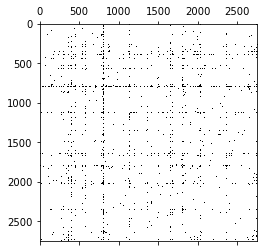

In [15]:
matrixconnectivity=compute_matrixconnectivity(features)
plt.spy(matrixconnectivity)
nbingredients=features.shape[1]
nbrecettes=features.shape[0]

In [16]:
meanconnectioningredients=matrixconnectivity.mean()
maxconnectivity=np.max(matrixconnectivity)
print("max connectivity : ", maxconnectivity)
print("mean connection : ", meanconnectioningredients, "\n")

print("Connexion ranking:")
mostconnexions=np.sort(matrixconnectivity.flatten())[-20:]
mostconnexions=[j for i,j in enumerate(mostconnexions) if i%2==0]
for i in range(len(mostconnexions)):
    index=np.where(matrixconnectivity==mostconnexions[len(mostconnexions)-1-i])
    print(df_clean.columns[index[0][0]], df_clean.columns[index[1][0]], mostconnexions[len(mostconnexions)-1-i])




max connectivity :  2448.0
mean connection :  0.08306265027326727 

Connexion ranking:
pepper salt 2448.0
onion salt 1579.0
salt sugar 1531.0
onion pepper 1529.0
flour salt 1383.0
egg salt 1300.0
egg sugar 1269.0
butter salt 1240.0
flour sugar 1216.0
egg flour 1090.0


2448.0


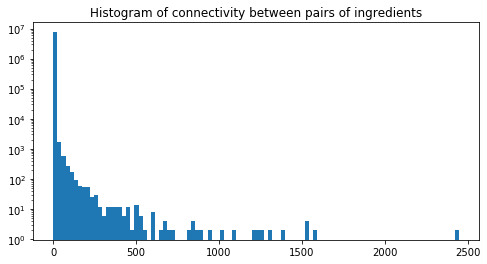

In [17]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of connectivity between pairs of ingredients")
plt.hist(matrixconnectivity.flatten(), log=True, bins=100)
print(matrixconnectivity.max())

In [18]:
def make_A_feature(connectivity, threshold, lower_threshold=0):
    A_feature = ((threshold <= connectivity)).astype(int)
    np.fill_diagonal(A_feature, 0)
    return A_feature

def cleanAfeature(A):
    cleaned=A.copy()
    deleted=0
    for i in range (len(A)):
        if sum( A[len(A)-1-i] )==0:
            deleted+=1
            cleaned=np.delete(cleaned,len(A_feature)-1-i , 0)
            cleaned=np.delete(cleaned,len(A_feature)-1-i, 1)
    print("deleted", deleted)
    return(cleaned)

Number of edges :  1402
Number of non connexions :  7583086
deleted 2623
nb colonnes A_feature :  2754
nb colonnes A_feature_cleaned :  131


''

C:\Users\Julien\Miniconda3\envs\ntds_2019\lib\site-packages\IPython\core\events.py:88: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  func(*args, **kwargs)


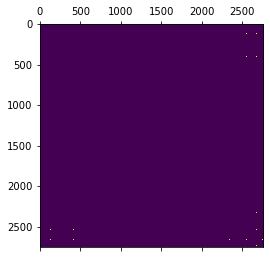

C:\Users\Julien\Miniconda3\envs\ntds_2019\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  fig.canvas.print_figure(bytes_io, **kw)


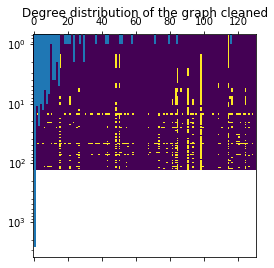

In [19]:
Threshold=50
print( "Number of edges : " , sum(sum(matrixconnectivity>Threshold)))
print( "Number of non connexions : " ,sum(sum(matrixconnectivity<Threshold)))

A_feature = make_A_feature(matrixconnectivity, Threshold)
A_featurecleaned= cleanAfeature(A_feature)

print('nb colonnes A_feature : ', len(A_feature))
print('nb colonnes A_feature_cleaned : ', len(A_featurecleaned))

plt.matshow(A_feature)
plt.matshow(A_featurecleaned)

plt.hist(sum(A_feature), log=True, bins=100)
plt.title('Degree distribution of the graph cleaned')
""

In [20]:
num_edges_feature = A_featurecleaned.sum()/2
print("Number of edges in the feature cleaned graph: {}".format(num_edges_feature))

Number of edges in the feature cleaned graph: 715.0


Text(0.5, 1.0, 'Degree distribution of the cleaned graph')

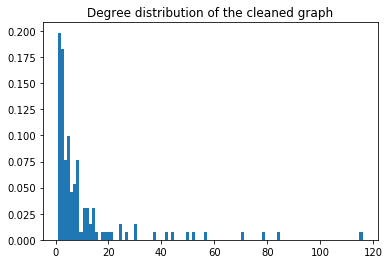

In [21]:
degrees_feature = A_featurecleaned.sum(1)

deg_hist_normalization = np.ones(degrees_feature.shape[0]) / degrees_feature.shape[0]

plt.hist(degrees_feature, weights=deg_hist_normalization, bins=100);
plt.title("Degree distribution of the cleaned graph")

In [22]:
degfs, counts_feat = np.unique(degrees_feature, return_counts=True)
degfeatprobs = counts_feat / counts_feat.sum()
feat_moment_1 = (degfs*degfeatprobs).sum()
feat_moment_2 = (degfs*degfs*degfeatprobs).sum()
print(f"1st moment of feature graph: {feat_moment_1}")
print(f"2nd moment of feature graph: {feat_moment_2}")

1st moment of feature graph: 10.916030534351144
2nd moment of feature graph: 420.6717557251908


In [23]:
feature_graph = nx.from_numpy_matrix(A_featurecleaned)

In [24]:
print(feature_graph.number_of_selfloops)

<bound method Graph.number_of_selfloops of <networkx.classes.graph.Graph object at 0x000001D374E46DA0>>


In [25]:
def plot_graph(G, size=(30,30)):
    plt.figure(1,figsize=size) 
    nx.draw_networkx(G)
    plt.show()

C:\Users\Julien\Miniconda3\envs\ntds_2019\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


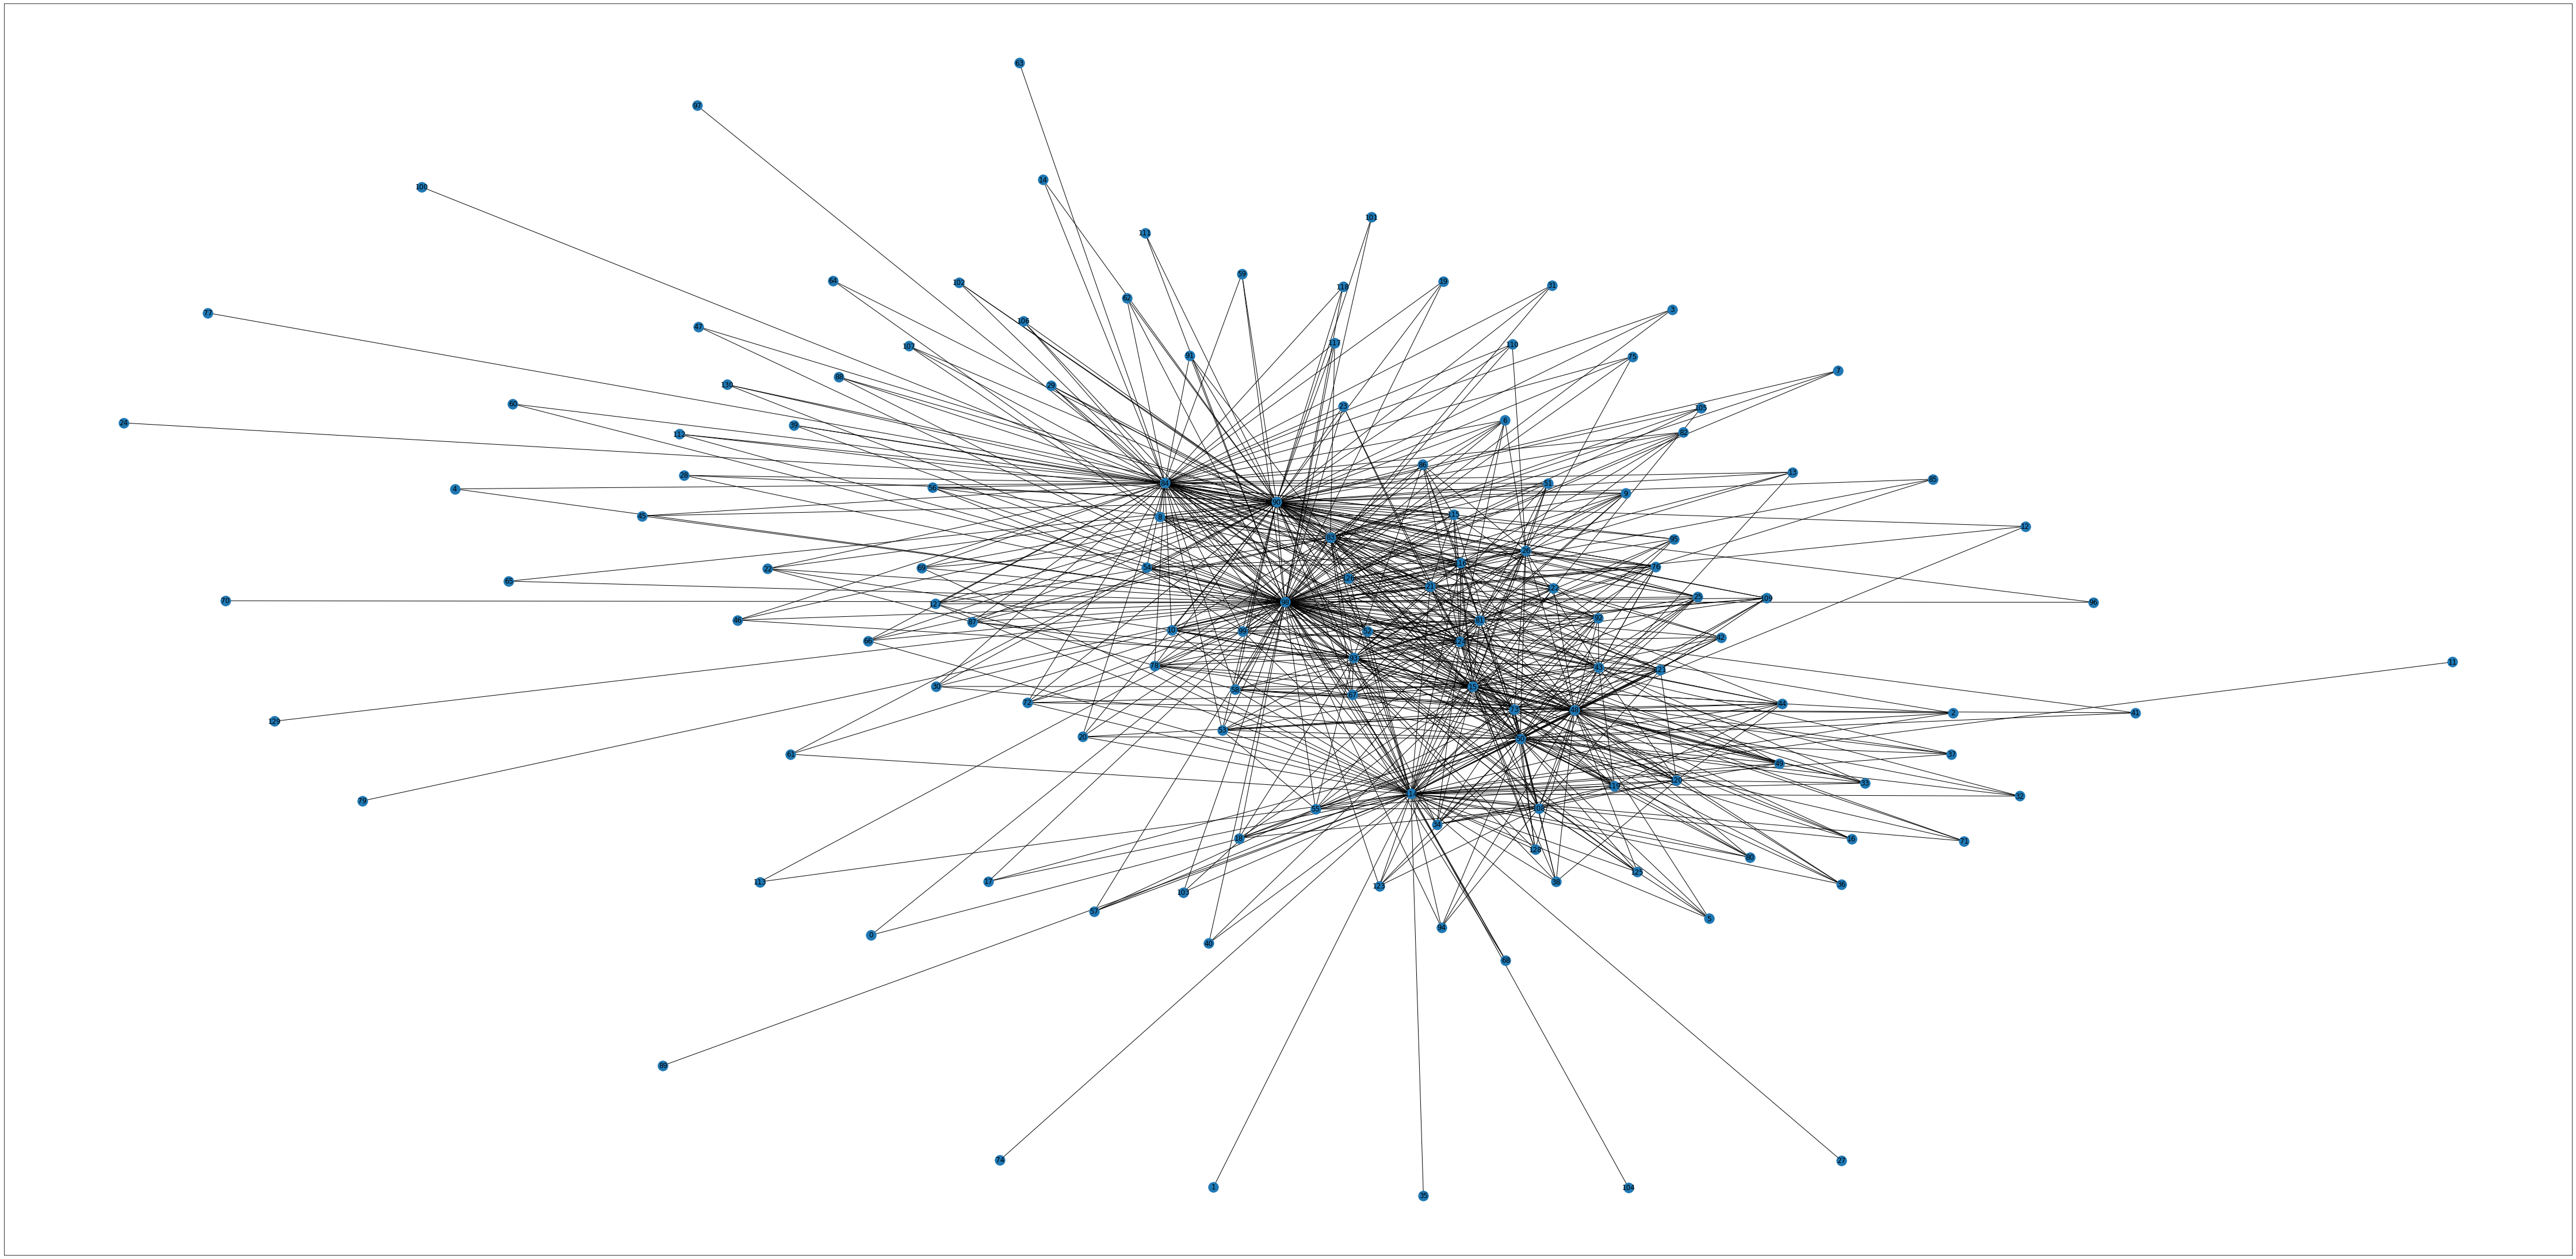

In [26]:
plot_graph(feature_graph, size=(80,40))

In [ ]:
#A AMELIORER POUR MIEUX CONTROLLER LE NOMBRE D'INGREDIENTS
def create_recipe(index_ingredient, nbingredients):
    listneighbours=[]
    listingredients=[index_ingredient]
    for i in range(nbingredients-1):
        #print(listingredients)
        # on prend un ingredient au hasard dans la liste
        choosen = random.choice(listingredients)
        #a:liste
        a=(A_featurecleaned[choosen])
        #print(a)
        #on regarde quels sont ses voisins
        listindneighbouringredients=[j for j, x in enumerate(a) if x]
        listneighbours=list(set(listneighbours+listindneighbouringredients))
        listingredients.append(random.choice(listneighbours))
    return listingredients

In [ ]:
listing=create_recipe(random.randint(0, len(A_featurecleaned)), random.randint(2, 10))
liste=[]
for i in listing:
    liste.append(df_clean.columns[i])
print(list(set(liste)))

delete the 20 higher hubs

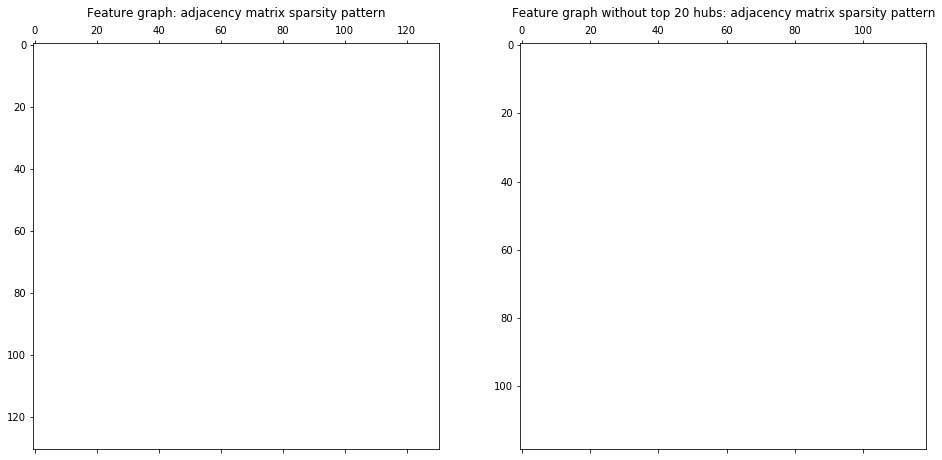

In [27]:
sort_feat = np.argsort(degrees_feature)
#sort_cit = np.argsort(degrees_citation)

reduced_A_feature = A_feature[sort_feat[:-12],:][:, sort_feat[:-12]]

A_feature = A_feature[sort_feat,:][:,sort_feat]
fig, axes = plt.subplots(1, 2, figsize=(16, 16))
axes[0].set_title('Feature graph: adjacency matrix sparsity pattern')
axes[0].spy(A_feature);
axes[1].set_title('Feature graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[1].spy(reduced_A_feature);

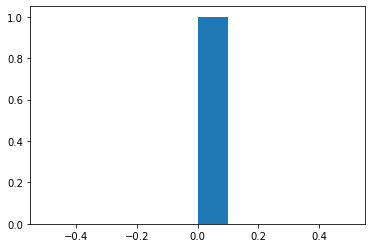

In [28]:
reduced_degrees_feat = reduced_A_feature.sum(1)
#reduced_degrees_cit = reduced_A_citation.sum(1)

deg_hist_normalization = np.ones(reduced_degrees_feat.shape[0]) / reduced_degrees_feat.shape[0]


plt.hist(reduced_degrees_feat, weights=deg_hist_normalization);

In [29]:
reduced_degfs, reduced_counts_feat = np.unique(reduced_degrees_feat,return_counts=True)
reduced_degfeatprobs = reduced_counts_feat / reduced_counts_feat.sum()
reduced_feat_moment_1 = (reduced_degfs*reduced_degfeatprobs).sum()
reduced_feat_moment_2 = (reduced_degfs*reduced_degfs*reduced_degfeatprobs).sum()
print("Feature graph first moment: ", reduced_feat_moment_1)
print("Feature graph second moment: ", reduced_feat_moment_2)

Feature graph first moment:  0.0
Feature graph second moment:  0.0


In [30]:
print("Feat graph edges", reduced_A_feature.sum() / 2)

Feat graph edges 0.0


In [31]:
path_lengths = range(11)
#path_matrix_citation = sum([np.linalg.matrix_power(A_citation, k) for k in path_lengths])
path_matrix_feature = sum([np.linalg.matrix_power(A_feature, k) for k in path_lengths])

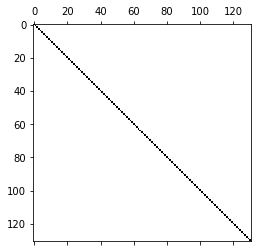

In [32]:
#fig, axes = plt.subplots(1, 1, figsize=(16, 9))
#axes[0].set_title('Feature Path matrix sparsity')
plt.spy(path_matrix_feature);

In [33]:
import networkx as nx
feature_graph = nx.from_numpy_matrix(A_feature)

print(f"Diameter according to networkx: {nx.diameter(feature_graph)}")

NetworkXError: Found infinite path length because the graph is not connected

In [ ]:
path_matrix_pruned = sum([np.linalg.matrix_power(A_feature_pruned, k) for k in path_lengths])

plt.figure(figsize=(12, 6))
plt.title('Feature Path matrix sparsity')
plt.spy(path_matrix_pruned);

**Properties of recipes**

In [ ]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between recipes")
plt.hist(distancerecipes.flatten());

In [ ]:
threshold = mean_distance

def compute_euclidean_distance(X):
    return  np.sqrt(-2 * np.dot(X, X.T) + np.sum(X**2, axis=1) + np.expand_dims(np.sum(X**2, axis=1), 1))

def make_A_feature(distance, threshold, lower_threshold=0):
    A_feature = ((lower_threshold <= distance) & (distance < threshold)).astype(int)
    np.fill_diagonal(A_feature, 0)
    return A_feature

A_feature = make_A_feature(distance, threshold)